In [4]:
import os
import re

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import  GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

from scipy.fft import fft
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#!conda install xgboost

# Lecture des fichiers

In [6]:
# directory = "Experimentations"
# df_names = []
# for root, directories, files in os.walk(directory):
#     for file_name in files:
#         if file_name.endswith(".xlsx"):
#             file_path = os.path.join(root, file_name)
#             var_add = file_path.split('\\')
#             data_frames = []
#             excel_file = pd.ExcelFile(file_path)
#             sheets = excel_file.sheet_names[:2]
#             for i in range(len(sheets)-1, -1, -1):
#                 data = excel_file.parse(sheets[i])
#                 data = data.drop(data.index[0])
#                 data_frames.append(data)
#                 df = pd.concat(data_frames, ignore_index=True)
#                 for elt in var_add[1:]:
#                     if elt != file_name:
#                         df[elt] = 1  
#                     else: 
#                         match = re.findall(r'(\d+%)', file_name)
#                         try:
#                             df["vitesse_a"] = match[0]
#                             df["vitesse_r"] = match[1]
#                         except:
#                             pass
#             df_name = "data_"+"_".join(var_add[1:]).replace(" ", "_").replace("'", "_")
#             df_names.append(df_name)
#             globals()[df_name] = df

In [7]:
acier_usure_75_75 = r".\Experimentations\Fraisage\Acier\Contrôle d'usure\Avec lubrifiant\40_2022_01_12_134028_75%_75%_L_US.xlsx"
acier_simp_75_75 = r".\Experimentations\Fraisage\Acier\Avec lubrifiant\19_2022_01_10_155909_75%_75%_L.xlsx"

acier_usure_120_100 = r".\Experimentations\Fraisage\Acier\Contrôle d'usure\Avec lubrifiant\39_2022_01_12_132408_120%_100%_L_US.xlsx"
acier_simp_120_100 = r".\Experimentations\Fraisage\Acier\Avec lubrifiant\13_2022_01_10_135525_120%_100%_L.xlsx"

In [8]:
def load_df(link):
    data_frames = []
    excel_file = pd.ExcelFile(link)
    sheets = excel_file.sheet_names[:2]
    for i in range(len(sheets)-1, -1, -1):
        data = excel_file.parse(sheets[i])
        data = data.drop(data.index[0])
        data_frames.append(data)
        merged_data = pd.concat(data_frames, ignore_index=True)
        merged_data["Time"] = merged_data["Time"].astype(float)
        merged_data["acc_broche"] = merged_data["acc_broche"].astype(float)
        merged_data["acc_table"] = merged_data["acc_table"].astype(float)
    return merged_data

In [123]:
df_us_75 = load_df(acier_usure_75_75) #df d'expé sur de l'acier usé à 75%, 75% et avec lubrifiant

In [124]:
df_75 = load_df(acier_simp_75_75) #df d'expé sur de l'acier à 75%, 75% et avec lubrifiant

In [125]:
df_us_120 = load_df(acier_usure_120_100)

In [126]:
df_120 = load_df(acier_simp_120_100)

In [13]:
df_us_75.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681056 entries, 0 to 1681055
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Time        1681056 non-null  float64
 1   acc_broche  1681056 non-null  float64
 2   acc_table   1681056 non-null  float64
dtypes: float64(3)
memory usage: 38.5 MB


In [14]:
def get4seq(df, lower_bound, upper_bound, train_end, test_start):
    df = df[df["Time"].between(lower_bound, upper_bound)]
    X_train = df[df["Time"].between(lower_bound, train_end)]
    X_test = df[df["Time"].between(test_start, upper_bound)]
    return df, X_train, X_test

In [15]:
def plot_data(df, X_train, X_test):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))
    ax1.plot(df['Time'], df[['acc_broche', 'acc_table']])
    ax2.plot(X_train['Time'], X_train[['acc_broche', 'acc_table']])
    ax2.set_title('Train set')
    ax3.plot(X_test['Time'], X_test[['acc_broche', 'acc_table']])
    ax3.set_title('Test set')
    plt.show()

In [16]:
lower_bound = 687.0000
upper_bound = 822.5000
df_us_75, X1_train, X1_test = get4seq(df_us_75, lower_bound, upper_bound, 789.5000, 801.0000)

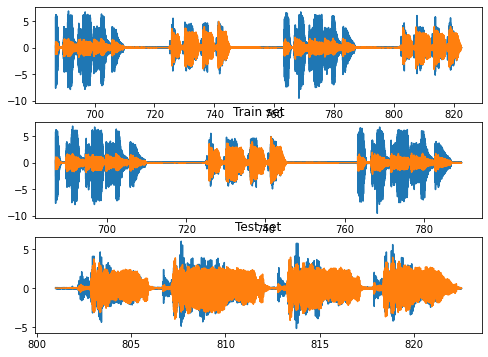

In [17]:
plot_data(df_us_75, X1_train, X1_test)

In [18]:
lower_bound = 691.0000
upper_bound = 827.5000
df_75, X2_train, X2_test = get4seq(df_75, lower_bound, upper_bound, 792.5000, 807.5000)

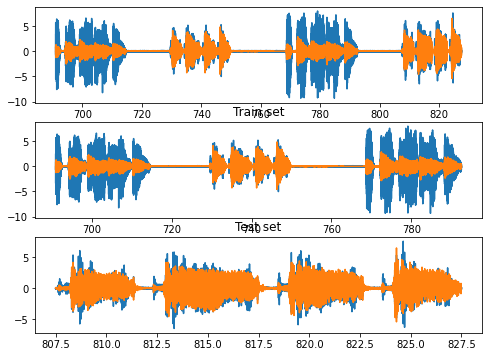

In [19]:
plot_data(df_75, X2_train, X2_test)

In [20]:
lower_bound = 449.0000
upper_bound = 534.5000
df_us_120, X3_train, X3_test = get4seq(df_us_120, lower_bound, upper_bound, 512.5000, 521.5000)

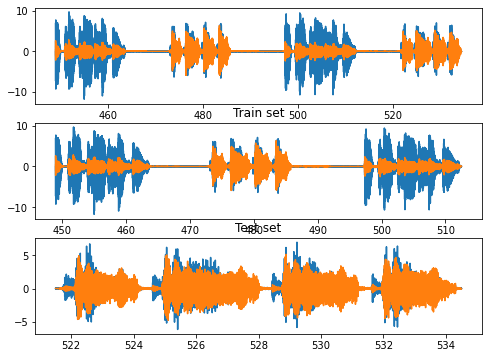

In [21]:
plot_data(df_us_120, X3_train, X3_test)

In [22]:
lower_bound = 438.0000
upper_bound = 524.5000
df_120, X4_train, X4_test = get4seq(df_120, lower_bound, upper_bound, 503.5000, 512.0000)

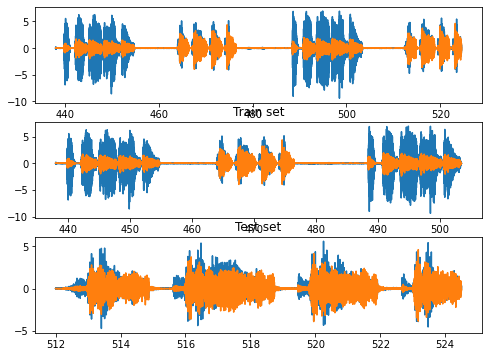

In [23]:
plot_data(df_120, X4_train, X4_test)

In [24]:
train = {1:[X1_train, X3_train], 0:[X2_train, X4_train]}
test = {1:[X1_test, X3_test], 0:[X2_test, X4_test]}

In [25]:
train

{1: [             Time  acc_broche  acc_table
  1374000  687.0000    0.309724   0.003880
  1374001  687.0005   -0.572312   0.486797
  1374002  687.0010    1.139196  -0.208678
  1374003  687.0015   -1.480980   0.593135
  1374004  687.0020    2.184528  -1.032807
  ...           ...         ...        ...
  1578996  789.4980   -0.003266  -0.008389
  1578997  789.4985    0.011975  -0.008549
  1578998  789.4990   -0.010111  -0.007909
  1578999  789.4995    0.020950  -0.006928
  1579000  789.5000    0.018113  -0.006763
  
  [205001 rows x 3 columns],
               Time  acc_broche  acc_table
  898000   449.0000   -0.089700   0.342146
  898001   449.0005   -1.452264   0.002744
  898002   449.0010    0.044999   0.334260
  898003   449.0015   -1.867965  -0.482561
  898004   449.0020    7.009129  -0.902119
  ...           ...         ...        ...
  1024996  512.4980    0.011863  -0.003501
  1024997  512.4985   -0.009868  -0.000670
  1024998  512.4990    0.044889  -0.000655
  1024999  512.4995

# Architecture piepline

In [121]:
def stat(groupe):
    stats = groupe.agg(['std', 'median', 'max', 'min'])
    # Transposer le DataFrame et aplatir les colonnes
    df_flat = stats.stack()
    df_flat = df_flat.T.reset_index()
    df_flat["column"] = df_flat["level_0"]+"_"+df_flat["level_1"]
    df_flat.drop(["level_0", "level_1"], inplace=True, axis=1)
    df_flat["values"] = df_flat[0]
    df_flat.drop(df_flat.columns[0], axis=1, inplace=True)
    df_stats = df_flat.set_index("column")
    df_stats = df_stats.transpose()
    return df_stats

In [122]:
def car(df, w_size):
    
    """Fonction qui retourne un df de caractéristiques 
    telles que le ratio d'energie, 
    le crete à crete, l'écart type, le rms et le crest fatcor"""

    j=0
    df_new = pd.DataFrame()
    df_stats = pd.DataFrame()
    ## Calcul de l'énergie totale pour deduire le ratio d'energie
    acc_table = df['acc_table'].tolist()
    acc_broche = df['acc_broche'].tolist()
    fft_table = fft(acc_table)
    fft_broche = fft(acc_broche)
    tot_energy_table = np.sum(np.abs(fft_table)**2)
    tot_energy_broche = np.sum(np.abs(fft_broche)**2)
    for i in range(0, len(df), w_size):
        df_car = {}
        groupe = df.iloc[i:i+w_size]
        df_stat = stat(groupe) # Calcul des stats (median, std, min, max)
        ## Energy ratio
        # Calcul de la transformée de fourier
        fft_table = fft(groupe['acc_table'].tolist())
        fft_broche = fft(groupe['acc_broche'].to_list())
        # Calcul de l'energie totale par groupe
        energy_table = np.sum(np.abs(fft_table))
        energy_broche = np.sum(np.abs(fft_broche))
        # Calcul du ratio d'énergie
        energy_ratio_table = energy_table / tot_energy_table
        df_car['energy_table'] = round(energy_table, 4)
        df_car['energy_broche'] = round(energy_broche, 4)
        ## Peak to Peak
        peak_to_peak_table = round(max(groupe['acc_table']) - min(groupe['acc_table']), 4) 
        peak_to_peak_broche = round(max(groupe['acc_broche']) - min(groupe['acc_broche']), 4)
        df_car['peak_to_peak_table'] = peak_to_peak_table
        df_car['peak_to_peak_broche'] = peak_to_peak_broche
        ## standard deviation
        std_deviation_table = np.std(groupe['acc_table'].tolist())
        std_deviation_broche = np.std(groupe['acc_broche'].tolist())
        df_car['std_deviation_table'] = round(std_deviation_table, 4)
        df_car['std_deviation_broche'] = round(std_deviation_broche, 4)
        ## Root mean Square 
        rms_table = np.sqrt(np.mean(np.square(groupe['acc_table'].tolist())))
        rms_broche = np.sqrt(np.mean(np.square(groupe['acc_broche'].tolist())))
        df_car['rms_table'] = round(rms_table, 4)
        df_car['rms_broche'] = round(rms_broche, 4)
        ## Crest factor
        peak_value_table = np.max(groupe["acc_table"].tolist())
        peak_value_broche = np.max(groupe["acc_broche"].tolist())
        crest_factor_table = peak_value_table / rms_table
        crest_factor_broche = peak_value_broche / rms_broche
        df_car['crest_factor_table'] = round(crest_factor_table, 4)
        df_car['crest_factor_broche'] = round(crest_factor_broche, 4)
        ## skewness (asymétrie)
        skew_table = skew(groupe['acc_table'].tolist())
        skew_broche = skew(groupe['acc_broche'].tolist())
        df_car['skew_table'] = round(skew_table, 4)
        df_car['skew_broche'] = round(skew_broche, 4)
        ## Kurtosis (Aplatissement)
        kurtosis_table = kurtosis(groupe['acc_table'].tolist())
        kurtosis_broche = kurtosis(groupe['acc_broche'].tolist())
        df_car['kurtosis_table'] = round(kurtosis_table, 4)
        df_car['kurtosis_broche'] = round(kurtosis_broche, 4)
        df_car = pd.DataFrame(df_car, index=[j])
        j+=1
        #display(df_car)
        df_new = pd.concat([df_new, df_car], axis=0)
        df_stats = pd.concat([df_stats, df_stat], axis=0)
        df_stats = df_stats.reset_index(drop=True)
    X = pd.concat([df_new, df_stats], axis=1)
    return X

In [91]:
def create_train_test(train, method, w_size):
    X1  = pd.DataFrame()
    X0  = pd.DataFrame()
    for y, x in train.items():
        if y==1:
            for d in x:
                data = car(d, w_size)
                data = data.dropna()
                X1 = pd.concat([X1, data], axis=0)
        elif y==0:
            for d in x:
                data = car(d, w_size)
                data = data.dropna()
                X0 = pd.concat([X0, data], axis=0)
    Y1 = np.ones(X1.shape[0])
    Y0 = np.zeros(X0.shape[0])
    print(f'{Y1.shape} class 1 values')
    print(f'{Y0.shape} class 30 values')
    X = pd.concat([X1, X0])
    Y = np.concatenate([Y1, Y0])
    return X, Y

In [92]:
X_train, y_train = create_train_test( train, "caracteristics", 2000)

(167,) class 1 values
(168,) class 0 values


In [93]:
X_test, y_test = create_train_test( test, "caracteristics", 2000)

(35,) class 1 values
(33,) class 0 values


In [116]:
class Model():
    def __init__(
        self,
        X_train,
        X_test,
        y_train,
        y_test,
        method,
        estimator_model,
        w_size = [0]  
    ):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.estimator_model = estimator_model
        self.accuracy = []
        self.precision = []
        self.f1 = []
        
    def run(self):
        names = []
        for name, model in self.estimator_model.items():
            print(f"<==========================Training started for {name} ==========================>")
            model.fit(self.X_train, self.y_train)
            print(f'best params : {model.best_params_}')
            y_pred = model.predict(self.X_test)
            sns.heatmap(pd.DataFrame(confusion_matrix(self.y_test, y_pred)) , annot=True, cmap="YlGnBu", fmt="g")
            plt.show()
            names.append(name)
            self.compute_metrics(y_pred)
        print(f"Accuracy: {self.accuracy}")
        print(f"Precision: {self.precision}")
        print(f"F1: {self.f1}")
        self.plot(names)
            
    
    def compute_metrics(self, y_pred) :
        self.accuracy.append(accuracy_score(self.y_test, y_pred))
        self.precision.append(precision_score(self.y_test, y_pred))
        self.f1.append(f1_score(self.y_test, y_pred))
        
    def plot(self, name):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))
        ax1.bar( name, self.accuracy)
        ax1.set_title("accuracy")
        ax2.bar( name, self.precision)
        ax2.set_title("Precision")
        ax3.bar(name, self.f1)
        ax3.set_title("F1")
        plt.show()
                  

## Analyse des 4 dernières séquences avec les données brutes

In [117]:
#Modele de machine learning simple
knn_model = KNeighborsClassifier()
rdf_model = RandomForestClassifier()
logr_model = LogisticRegression()
# xgb_model = XGBClassifier()

## Definition of grids
knn_grid = {
    'n_neighbors': [i for i in range(3,33,2)],
    'p':[1, 2]
}

rdf_grid = {
    'n_estimators': [50, 100, 150],
    'max_features' : ["sqrt", "log2", None]
}

logr_grid = {
    'penalty':['l1', 'l2', 'elasticnet', None]
}

In [118]:
gs_knn = GridSearchCV(knn_model, knn_grid, cv=5)
gs_rdf = GridSearchCV(rdf_model, rdf_grid, cv=5)
gs_logr = GridSearchCV(logr_model, logr_grid, cv=5)

In [119]:
models_train = {
    "knn": gs_knn,
    "rdf": gs_rdf
    #"logr": gs_logr
}

Start for Window size = 100 ============================================>
train set
(3320,) class 1 values
(3340,) class 0 values
test set
(690,) class 1 values
(650,) class 0 values
<==========================Training started for knn ==========================>
best params : {'n_neighbors': 21, 'p': 2}


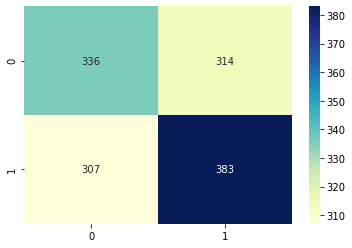

<==========================Training started for rdf ==========================>
best params : {'max_features': 'log2', 'n_estimators': 50}


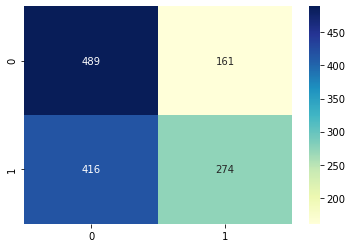

Accuracy: [0.5365671641791044, 0.5694029850746268]
Accuracy: [0.5494978479196556, 0.6298850574712643]
F1: [0.5522710886806057, 0.48711111111111116]


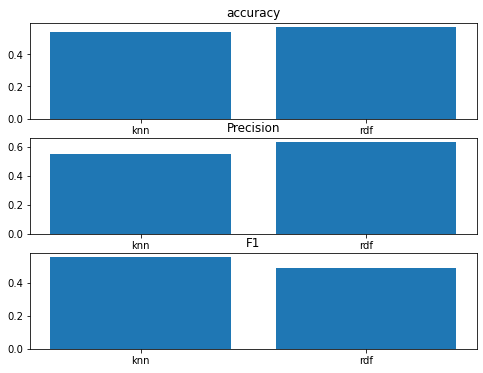

 End for Window size = 100 ============================================>
Start for Window size = 500 ============================================>
train set
(664,) class 1 values
(668,) class 0 values
test set
(138,) class 1 values
(130,) class 0 values
<==========================Training started for knn ==========================>
best params : {'n_neighbors': 9, 'p': 1}


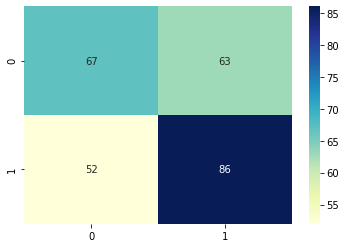

<==========================Training started for rdf ==========================>
best params : {'max_features': None, 'n_estimators': 50}


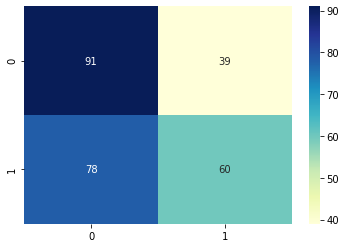

Accuracy: [0.5708955223880597, 0.5634328358208955]
Accuracy: [0.5771812080536913, 0.6060606060606061]
F1: [0.5993031358885018, 0.5063291139240507]


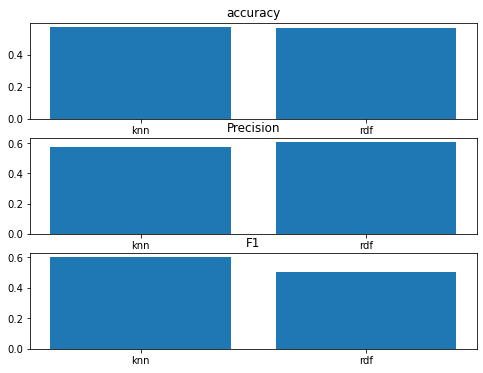

 End for Window size = 500 ============================================>
Start for Window size = 1000 ============================================>
train set
(332,) class 1 values
(334,) class 0 values
test set
(69,) class 1 values
(65,) class 0 values
<==========================Training started for knn ==========================>
best params : {'n_neighbors': 3, 'p': 1}


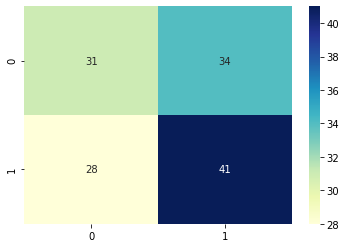

<==========================Training started for rdf ==========================>
best params : {'max_features': 'sqrt', 'n_estimators': 50}


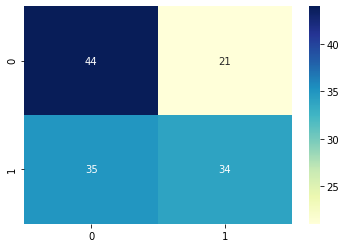

Accuracy: [0.5373134328358209, 0.582089552238806]
Accuracy: [0.5466666666666666, 0.6181818181818182]
F1: [0.5694444444444444, 0.5483870967741936]


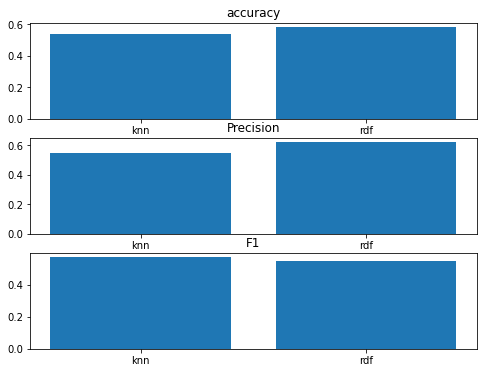

 End for Window size = 1000 ============================================>
Start for Window size = 1500 ============================================>
train set
(222,) class 1 values
(224,) class 0 values
test set
(47,) class 1 values
(44,) class 0 values
<==========================Training started for knn ==========================>
best params : {'n_neighbors': 15, 'p': 2}


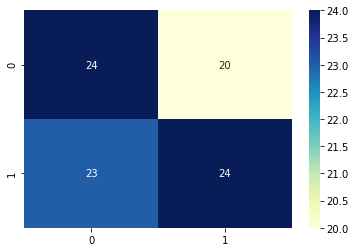

<==========================Training started for rdf ==========================>
best params : {'max_features': 'log2', 'n_estimators': 50}


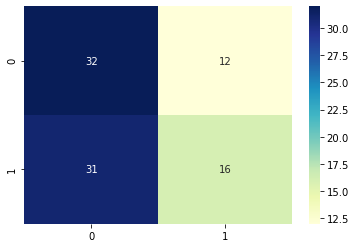

Accuracy: [0.5274725274725275, 0.5274725274725275]
Accuracy: [0.5454545454545454, 0.5714285714285714]
F1: [0.5274725274725275, 0.4266666666666666]


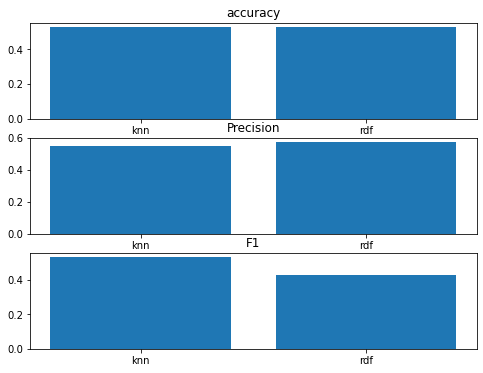

 End for Window size = 1500 ============================================>
Start for Window size = 2000 ============================================>
train set
(167,) class 1 values
(168,) class 0 values
test set
(35,) class 1 values
(33,) class 0 values
<==========================Training started for knn ==========================>
best params : {'n_neighbors': 11, 'p': 2}


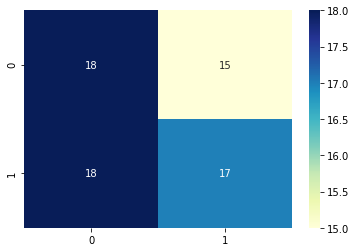

<==========================Training started for rdf ==========================>
best params : {'max_features': 'sqrt', 'n_estimators': 100}


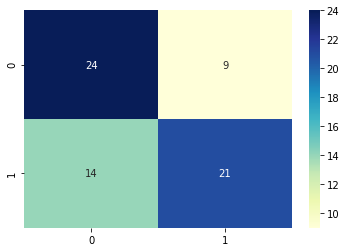

Accuracy: [0.5147058823529411, 0.6617647058823529]
Accuracy: [0.53125, 0.7]
F1: [0.5074626865671641, 0.6461538461538462]


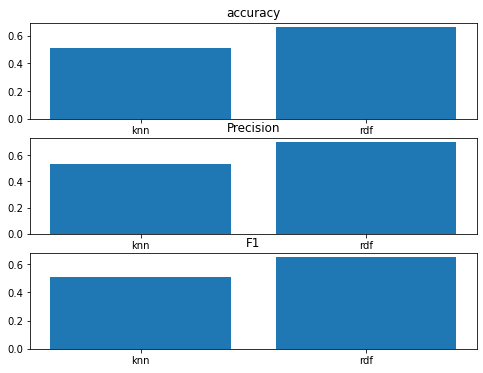

 End for Window size = 2000 ============================================>


In [120]:
method = "caracteristics"
w_sizes = [100, 500, 1000, 1500, 2000]
model_estimator = models_train
for w_size in w_sizes:
    print(f'Start for Window size = {w_size} ============================================>')
    print('train set')
    X_train, y_train = create_train_test( train, method, w_size)
    print('test set')
    X_test, y_test = create_train_test( test, method, w_size)
    model = Model(X_train, X_test, y_train, y_test, method, model_estimator)
    model.run()
    print(f' End for Window size = {w_size} ============================================>')